## Laboratorio LSTM

En este laboratorio utilizaremos Redes LSTM para aprender a clasificar Tweets según su sentimiento (positivo/negativo/neutro).

Trabajaremos sobre el dataset del challenge [TASS 2020](http://tass.sepln.org/2020/). Este dataset contiene tweets en español anotados con su respectiva polaridad de sentimiento (P: positivo, N: negativo, NEU: neutro).

En particular utilizaremos los tweets correspondientes a Uruguay que fueron anotados por el Grupo de PLN de la Facultad de Ingeniería.

## Preparación de los datos

Para empezar importaremos el dataset a utilizar y visualezaremos la estructura de los datos.


In [94]:
import os
import pandas as pd

# Descomprimimos el archivo y verificamos

! wget https://eva.fing.edu.uy/pluginfile.php/357781/mod_folder/content/0/tass2020.tar.gz
! tar -zxf tass2020.tar.gz
assert os.path.isfile('tass2020/train/uy.tsv'), 'No se encontró el archivo; asegurate de haberlo cargado'
assert os.path.isfile('tass2020/dev/uy.tsv'), 'No se encontró el archivo; asegurate de haberlo cargado'
assert os.path.isfile('tass2020/test/uy.tsv'), 'No se encontró el archivo; asegurate de haberlo cargado'

# Agregamos etiquetas a los atributos
data_train = pd.read_csv('tass2020/train/uy.tsv', sep='\t', names=['id', 'text', 'polarity'])
data_dev = pd.read_csv('tass2020/dev/uy.tsv', sep='\t', names=['id', 'text', 'polarity'])
data_test = pd.read_csv('tass2020/test/uy.tsv', sep='\t', names=['id', 'text', 'polarity'])

# Eliminamos el atributo 'id'
data_train.drop(['id'], axis=1, inplace=True)
data_dev.drop(['id'], axis=1, inplace=True)
data_test.drop(['id'], axis=1, inplace=True)


--2023-09-27 21:34:38--  https://eva.fing.edu.uy/pluginfile.php/357781/mod_folder/content/0/tass2020.tar.gz
Resolving eva.fing.edu.uy (eva.fing.edu.uy)... 164.73.32.9
Connecting to eva.fing.edu.uy (eva.fing.edu.uy)|164.73.32.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142038 (139K) [application/g-zip]
Saving to: ‘tass2020.tar.gz.1’

tass2020.tar.gz.1   100%[===================>] 138.71K   323KB/s    in 0.4s    

2023-09-27 21:34:39 (323 KB/s) - ‘tass2020.tar.gz.1’ saved [142038/142038]



In [95]:
# Separamos los atributos de la clase objetivo
X_train_text = data_train['text']
y_train_text = data_train['polarity'].values

X_dev_text = data_dev['text']
y_dev_text = data_dev['polarity'].values

X_test_text = data_test['text']
y_test_text = data_test['polarity'].values

In [96]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

max_length = 50

# Toquenizamos las palabras
t = Tokenizer()
t.fit_on_texts(X_train_text)

X_train = t.texts_to_sequences(X_train_text)
X_dev = t.texts_to_sequences(X_dev_text)
X_test = t.texts_to_sequences(X_test_text)

# Agregamos padding
X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_dev = sequence.pad_sequences(X_dev, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [97]:
from sklearn.preprocessing import LabelEncoder

# Convertimos las etiquetas a enteros
le = LabelEncoder()
le.fit(["P", "NEU", "N"])
y_train = le.transform(y_train_text)
y_dev = le.transform(y_dev_text)
y_test = le.transform(y_test_text)


In [98]:
le.transform(["P", "NEU", "N"])

array([2, 1, 0])

### Ejercicio 1 - Descripción de los datos

1. Visualice y describa la estructura de los distintos atributos y la clase objetivo.
1. ¿Cuántos ejemplos tiene en total cada partición (entrenamiento y evaluación)?
1. ¿Y para cada valor de la clase objetivo?

In [99]:
# Código para responder las preguntas
print(data_dev.columns)
import numpy as np
# Entrenamiento
print ('---------- ENTRENAMIENTO ----------')
for label,count in zip(np.unique(y_train, return_counts = True)[0], np.unique(y_train, return_counts = True)[1]):
  print (f'Clase {label}: {count} ejemplos')
print(f'Total: {len(X_train)} ejemplos')

# Validación
y_dev = le.transform(y_dev_text)
print ('\n---------- VALIDACIÓN ----------')
for label,count in zip(np.unique(y_dev, return_counts = True)[0], np.unique(y_dev, return_counts = True)[1]):
  print (f'Clase {label}: {count} ejemplos')
print(f'Total: {len(X_dev)} ejemplos')

Index(['text', 'polarity'], dtype='object')
---------- ENTRENAMIENTO ----------
Clase 0: 367 ejemplos
Clase 1: 286 ejemplos
Clase 2: 290 ejemplos
Total: 943 ejemplos

---------- VALIDACIÓN ----------
Clase 0: 183 ejemplos
Clase 1: 134 ejemplos
Clase 2: 147 ejemplos
Total: 464 ejemplos


Respuestas:
1. Se cuenta con 3 conjuntos de datos dentro del dataset. Cada conjunto cuenta con únicamente 2 columnas. La primera tiene el texto del tweet (columna text), mientras que la segunda contiene la calificación que se le da al tweet. Las calificaciones pueden ser "P" (positiva), "N" (negativa), y "NEU" (neutro).
2. El conjunto de entrenamiento tiene 943 ejemplos, mientras que el de validación tiene 464 ejemplos.
3. El conjunto de entrenamiento tiene 367 ejemplos pertenecientes a la clase 0 (calificación negativa), 286 ejemplos pertenecientes a la clase 1 (calificación neutra), y 290 ejemplos pertenecientes a la clase 2 (calificación positiva).

  El conjunto de validación tiene 183 ejemplos pertenecientes a la clase 0 (calificación negativa), 134 ejemplos pertenecientes a la clase 1 (calificación neutra), y 147 ejemplos pertenecientes a la clase 2 (calificación positiva)



## Implementación de la Red Neuronal en Keras

A continuación implementaremos la red LSTM utilizando Keras.

### Ejercicio 2 - Descripción de la red

1. ¿Qué tipo de RNN utilizaría para esta tarea?
1. ¿Y qué tipo de función de activación? ¿Por qué?


Respuestas:
1. Una RNN con arquitectura Many to One, ya que se estaría introduciendo una secuencia de palabras a la red y se desea obtener una única palabra de salida, correspondiente a la calificación del tweet.
2. Dado que el problema es de clasificación multiclass (P, NEU, N), conviene utilizar una función de activación que devuelva la probabilidad de cada una de las clases. Para ello, es posible utilizar la función de activación softmax.

### Ejercicio 3 - Implementación de la red


Implemente una red neuronal con las siguientes características para resolver el problema planteado:

1. Entrada
1. Capa LSTM, de 32 unidades
1. Activación


In [100]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

In [101]:
# Implementación del ejercicio 3
model = Sequential(name = 'my_recurrent_model')
model.add(LSTM(32, input_shape = (50,1), name = 'lstm'))
model.add(Dense(3, activation = 'softmax', name = 'output_layer'))

### Ejercicio 4 - Compilación del modelo

Compile el modelo utilizando:

* Optimizador: Adam con learning rate de 0.01
* Métrica de optimización: Accuracy
* Función de loss adecuada

In [102]:
# Implementación del ejercicio 4
from keras.optimizers import Adam

model.compile(
            optimizer = Adam(learning_rate = 0.01),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

Model: "my_recurrent_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 output_layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 4451 (17.39 KB)
Trainable params: 4451 (17.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


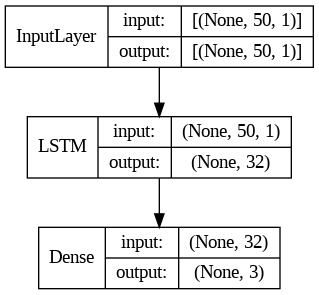

In [103]:
# Visualización del modelo
model.summary()
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Entrenamiento del modelo


### Ejercicio 5 - Entrenamiento de la red


Entrene el modelo anterior durante 20 épocas utilizando adecuadamente los datos de entrenamiento y validación.

In [104]:
# Implementación del ejercicio 5
model.fit(x = X_train,
          y = y_train,
          epochs = 20,
          batch_size = 32,
          validation_data = (X_dev, y_dev)
          )

Epoch 1/20
30/30 [==============================] - 6s 33ms/step - loss: 1.1094 - accuracy: 0.3712 - val_loss: 1.0931 - val_accuracy: 0.4203
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 1.0924 - accuracy: 0.3892 - val_loss: 1.0985 - val_accuracy: 0.4159
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 1.0823 - accuracy: 0.4019 - val_loss: 1.0993 - val_accuracy: 0.4203
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 1.0842 - accuracy: 0.3987 - val_loss: 1.1025 - val_accuracy: 0.4267
Epoch 5/20
30/30 [==============================] - 0s 15ms/step - loss: 1.0789 - accuracy: 0.4062 - val_loss: 1.0844 - val_accuracy: 0.4267
Epoch 6/20
30/30 [==============================] - 0s 16ms/step - loss: 1.0759 - accuracy: 0.4189 - val_loss: 1.0813 - val_accuracy: 0.4440
Epoch 7/20
30/30 [==============================] - 0s 15ms/step - loss: 1.0821 - accuracy: 0.4051 - val_loss: 1.1103 - val_accuracy: 0.4224
Epoch 8/20
30

### Visualización


In [105]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

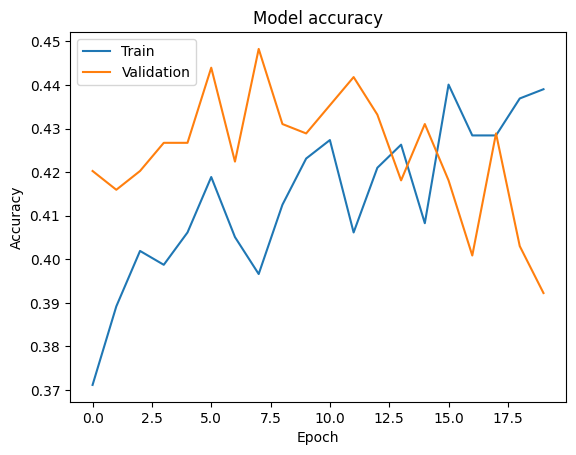

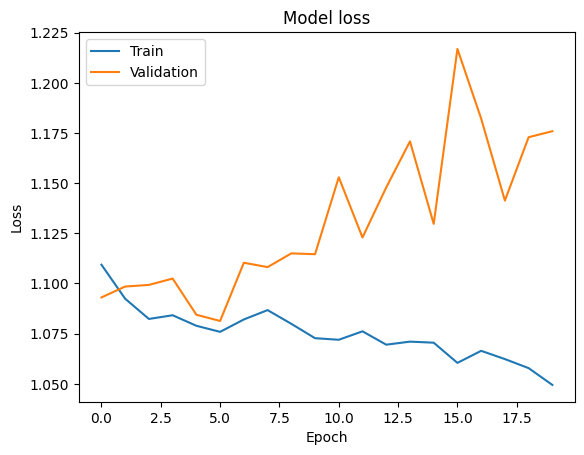

<Figure size 640x480 with 0 Axes>

In [106]:
plot_history(model.history)

## Evaluación del modelo

### Ejercicio 6 - Evaluación

Evalúe el modelo anterior utilizando los datos de test. ¿Qué accuracy tuvo el modelo?

In [107]:
from sklearn.metrics import classification_report
# Implementación del ejercicio 6
predictions = model.predict(X_test) # predicciones sobre el conjunto de testeo
print (f'Forma del conjunto de predicciones: {predictions.shape}')

y_test_pred = np.argmax(predictions, axis=1) # Obtener etiquetas predichas

print (classification_report(y_true = y_test, y_pred = y_test_pred, digits = 3, target_names = ["N", "NEU", "P"]))



45/45 [==============================] - 1s 5ms/step
Forma del conjunto de predicciones: (1428, 3)
              precision    recall  f1-score   support

           N      0.477     0.497     0.487       587
         NEU      0.263     0.140     0.182       372
           P      0.409     0.539     0.466       469

    accuracy                          0.418      1428
   macro avg      0.383     0.392     0.378      1428
weighted avg      0.399     0.418     0.401      1428



## Embeddings



### Embeddings pre-entrenados

Para esta parte utilizaremos los embeddings pre-entrenados de [Fasttext](https://fasttext.cc/) para español.

In [108]:
# Descargamos y descomprimimos los Embeddings
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
! gzip -d cc.es.300.vec.gz

--2023-09-27 21:34:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.111, 13.226.210.78, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.300.vec.gz’

cc.es.300.vec.gz    100%[===================>]   1.20G   163MB/s    in 11s     

2023-09-27 21:35:09 (110 MB/s) - ‘cc.es.300.vec.gz’ saved [1285580896/1285580896]

gzip: cc.es.300.vec already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [109]:
# Cargamos los embeddings
embeddings_index = {}
with open("cc.es.300.vec") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

In [110]:
# Preparamos la matriz de embeddings
num_tokens = len(t.word_index) + 2
embedding_dim = 300

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector

Ahora implemente, compile y visualice el siguiente modelo:

1. Entrada
1. **Capa de embeddings utilizando la matriz anterior**
1. Capa LSTM, de 32 unidades con
1. Activación Softmax


Model: "my_recurrent_model_with_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 50, 300)           1308900   
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 output_layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 1351623 (5.16 MB)
Trainable params: 1351623 (5.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


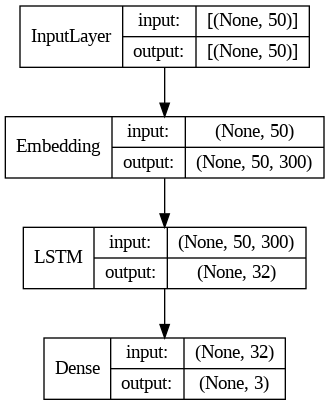

In [111]:
# Implementación del ejercicio 7
from keras.layers import Embedding

weights=[embedding_matrix]
model_emb = Sequential(name = 'my_recurrent_model_with_embeddings')
model_emb.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1], input_length = 50, weights = weights))
model_emb.add(LSTM(32, name = 'lstm'))
model_emb.add(Dense(3, activation = 'softmax', name = 'output_layer'))

# Compiling
model_emb.compile(
            optimizer = Adam(learning_rate = 0.01),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

model_emb.summary()
keras.utils.plot_model(model_emb, to_file='model.png', show_shapes=True, show_layer_names=False)

### Ejercicio 8 - Entrenamiento y visualización

Entrene el nuevo modelo

In [112]:
# Implementación del ejercicio 8
model_emb.fit(x = X_train,
          y = y_train,
          epochs = 10,
          batch_size = 32,
          validation_data = (X_dev, y_dev)
          )

Epoch 1/10
30/30 [==============================] - 10s 181ms/step - loss: 1.0580 - accuracy: 0.4252 - val_loss: 0.9658 - val_accuracy: 0.5216
Epoch 2/10
30/30 [==============================] - 5s 170ms/step - loss: 0.3051 - accuracy: 0.8887 - val_loss: 1.7900 - val_accuracy: 0.5065
Epoch 3/10
30/30 [==============================] - 3s 113ms/step - loss: 0.0538 - accuracy: 0.9820 - val_loss: 1.9358 - val_accuracy: 0.5323
Epoch 4/10
30/30 [==============================] - 2s 63ms/step - loss: 0.0191 - accuracy: 0.9936 - val_loss: 2.0011 - val_accuracy: 0.5022
Epoch 5/10
30/30 [==============================] - 1s 48ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 2.1640 - val_accuracy: 0.5043
Epoch 6/10
30/30 [==============================] - 2s 47ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 2.2671 - val_accuracy: 0.5108
Epoch 7/10
30/30 [==============================] - 2s 52ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 2.3341 - val_accuracy: 0.5129
Epoch 8/1

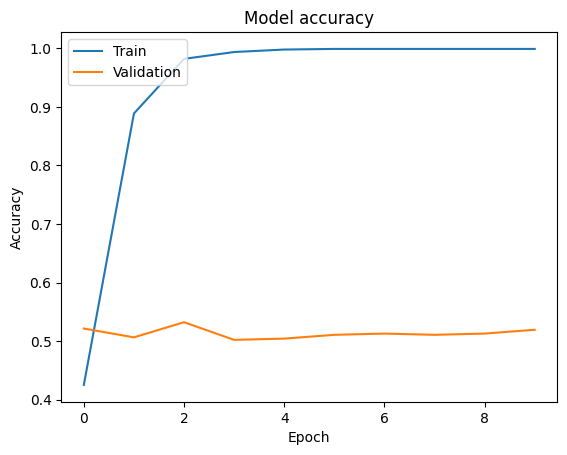

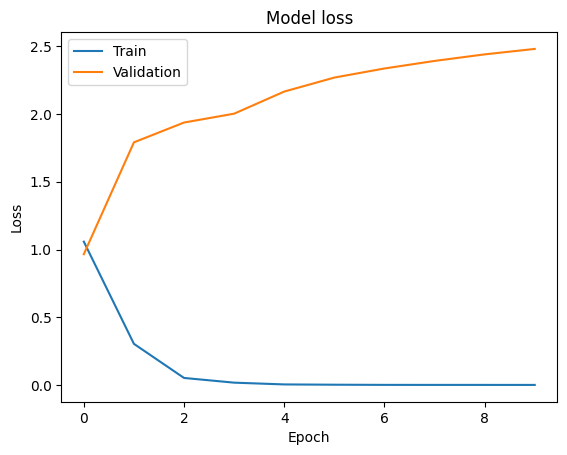

<Figure size 640x480 with 0 Axes>

In [113]:
# Visualizamos los resultados del entrenamiento
plot_history(model_emb.history)

### Ejercicio 9 - Mejorando el modelo

A partir de los resultados obtenidos en entrenamiento. ¿Cómo podemos mejorar el modelo?

**Respuesta:**

Los resultados obtenidos son muy buenos para el conjunto de entrenamiento, pero son bastante malos para el conjunto de validación. En particular, podemos ver que, mientras la accuracy del conjunto de entrenamiento aumenta rápidamente hacia 0.99 luego de la primera época, la accuracy del conjunto de validación permanece constante alrededor de 0.5. Respecto a la pérdida, la misma decrece con cada época en el conjunto de entrenamiento, mientras que aumenta con cada época en el conjunto de validación. Se deduce, entonces, que el modelo se está sobreajustando a los datos de entrenamiento, presentando problemas de generalización.

Se toman algunas medidas para evitar el sobreajuste del modelo. En primer lugar, se fija el parámetro **trainable** a False, en la capa de Embeddings, lo que hace que los pesos no sean actualizados durante el entrenamiento. Esto se hace para reducir la cantidad de parámetros, ya que se tienen pocos datos en el conjunto de entrenamiento y la cantidad de parámetros correspondientes a la capa de Embeddings es muy alta en relación a dicha cantidad de datos. Si se analiza el resumen del modelo antes y después de ajustar este parámetro, es posible ver como los 1308900 parámetros asociados a la capa de embeddings pasan a ser no entrenables, lo que ayudará a evitar el sobreajuste.

En segundo lugar, se aplica regularización L2 en la capa LSTM, utilizando $\lambda = 0.01$, lo que agregará un factor de penalización a los pesos altos en la función de costo que se busca minimizar.

En tercer lugar, se agrega una capa de Dropout con ratio de 0.5. Es decir, se "apagan" la mitad de las neuronas en cada pasada hacia adelante durante el entrenamiento del modelo. Esto permitirá que algunas neuronas que posiblemente contengan mucha información de los datos no sean consieradas en todos los casos, lo que puede contribuir a disminuir el sobreajuste.

Por último, se reduce el valor del learning rate de 0.01 a 0.00025, y se aumenta la cantidad de épocas de 10 a 20. Se probó con varias valores de learning rate en el rango de [0.0001 ; 0.01] y una cantidad de épocas entre 5 y 20, y se encontró que esta combinación era la que que tenía accuracy más alta en el conjunto de validación, mostrando un comportamiento muy similar entre el conjunto de entrenamiento y validación.

Agregue al modelo anterior las capas que sean necesarias.

In [114]:
# Implementacion del ejercicio 9
from keras import regularizers
from keras.layers import Dropout

model_emb_opt = Sequential(name = 'my_recurrent_model_with_embeddings')
model_emb_opt.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1], input_length = 50, weights = weights, trainable = False))
model_emb_opt.add(LSTM(32, name = 'lstm', kernel_regularizer = regularizers.l2(1e-2)))
model_emb_opt.add(Dropout(rate = 0.5, seed = 6))
model_emb_opt.add(Dense(3, activation = 'softmax', name = 'output_layer'))

# Compiling
model_emb_opt.compile(
            optimizer = Adam(learning_rate = 0.00025),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

model_emb_opt.summary()
keras.utils.plot_model(model_emb_opt, to_file='model.png', show_shapes=True, show_layer_names=False)

# Entrenamiento
model_emb_opt.fit(x = X_train,
          y = y_train,
          epochs = 20,
          batch_size = 32,
          validation_data = (X_dev, y_dev)
          )

Model: "my_recurrent_model_with_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 50, 300)           1308900   
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 3)                 99        
                                                                 
Total params: 1351623 (5.16 MB)
Trainable params: 42723 (166.89 KB)
Non-trainable params: 1308900 (4.99 MB)
_________________________________________________________________
Epoch 1/20
30/30 [==============================] - 4s 31ms/step - loss: 2.7590 - accuracy: 0.3160 - val_loss: 2.6002 - va

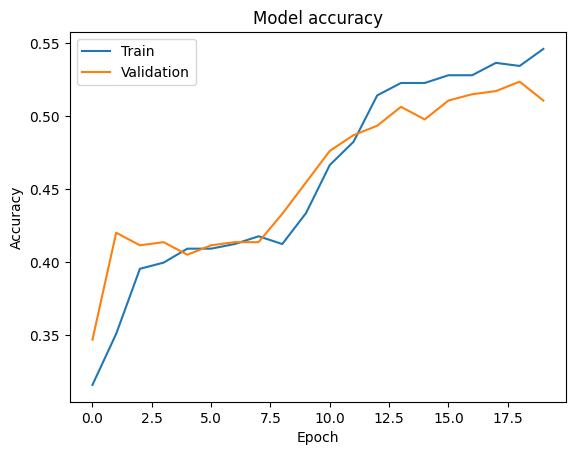

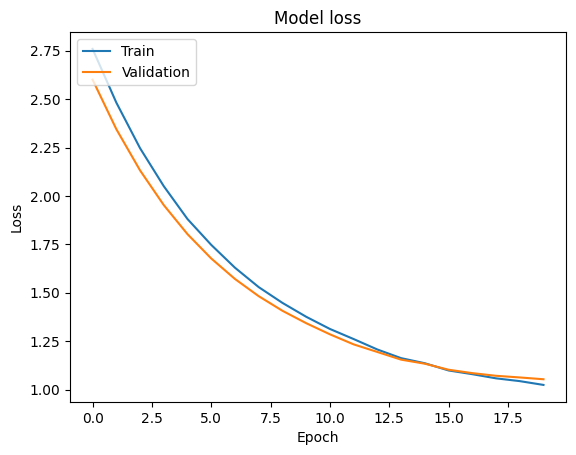

<Figure size 640x480 with 0 Axes>

In [115]:
plot_history(model_emb_opt.history)

### Ejercicio 10 - Evaluación

Evalúe el nuevo modelo utilizando los datos de test. ¿Qué accuracy obtuvo?

In [116]:
# Implementacion del ejercicio 10
predictions = model_emb_opt.predict(X_test) # predicciones sobre el conjunto de testeo
print (f'Forma del conjunto de predicciones: {predictions.shape}')

y_test_emb_pred = np.argmax(predictions, axis=1) # Obtener etiquetas predichas

print (classification_report(y_true = y_test, y_pred = y_test_emb_pred, digits = 3, target_names = ["N", "NEU", "P"]))

45/45 [==============================] - 1s 4ms/step
Forma del conjunto de predicciones: (1428, 3)
              precision    recall  f1-score   support

           N      0.536     0.722     0.615       587
         NEU      0.413     0.051     0.091       372
           P      0.540     0.680     0.602       469

    accuracy                          0.534      1428
   macro avg      0.496     0.485     0.436      1428
weighted avg      0.505     0.534     0.474      1428



## Conclusiones


### Ejercicio 11 - Conclusiones sobre mejora

1. Comentar brevemente los resultados obtenidos al agregar Embeddings.
1. ¿De qué otra forma podemos mejorar los resultados?


**Respuestas**
1. Los resultados mejoraron significativamente al agregar Embeddings. Para el caso sin Embeddings, la accuracy del modelo oscilaba en torno a 0.4, tanto para el conjunto de entrenamiento como para el de validación, mostrando un claro subajuste a los datos, es decir, el modelo no estaba aprendiendo correctamente. Cabe destacar que, dado que la clase 0 constituye cerca de un 40% de los ejemplos de entrenamiento y de validación, un clasificador trivial que clasificase todas los datos como dicha clase obtendría un valor de accuracy cercano al obtenido para el del modelo sin Embeddings. Al agregar Embeddings y ajustar el modelo para evitar el sobreajuste, fue posible llegar a un valor de accuracy de 0.50 para ambos conjuntos, es decir, se obtuvo un 25% de aumento en la métrica considerada.

  La razón de esta mejora radica en que los Embeddings añadidos al modelo ya contienen información pre-entrenada de las palabras de los tweets, mientras que la secüenciación basada en los índices de la tokenización realizada en el primer caso es realizada únicamente a los efectos de llevar los datos de entrada a un formato válido para alimentar la red. En cambio, los vectores de palabras añadidos por la capa de Embeddings ya fueron obtenidos considerando el contexto en que las palabras suelen aparecer en una enorme cantidad de documentos, incluyendo documentos de **Common Crawl** y **Wikipedia**.

2. Otra forma de mejorar los resultados sería conseguir más datos para alimentar al modelo, ya que se cuenta con muy pocos datos de entrenamiento y de validación, lo que puede condicionar el aprendizaje.

## Extra - Modelos de lenguaje

En esta sección veremos cómo importar un modelo pre entrenado de [Hugginface](https://huggingface.co/) y aplicarlo a nuestros datos.

En particular utilizaremos un modelo de Longformer entrenado para Question Answering es idioma español.

In [117]:
!pip install transformers
from transformers import pipeline

qa_pipe = pipeline("question-answering", model='mrm8488/longformer-base-4096-spanish-finetuned-squad')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00


In [118]:
context = '''
Hace aproximadamente un año, Hugging Face, una startup de procesamiento de lenguaje natural con sede en Brooklyn, Nueva York, lanzó BigScience, un proyecto internacional con más de 900 investigadores que está diseñado para comprender mejor y mejorar la calidad de los grandes modelos de lenguaje natural. Los modelos de lenguaje grande (LLM), algoritmos que pueden reconocer, predecir y generar lenguaje sobre la base de conjuntos de datos basados ​​en texto, han captado la atención de empresarios y entusiastas de la tecnología por igual. Pero el costoso hardware requerido para desarrollar LLM los ha mantenido en gran medida fuera del alcance de los investigadores sin los recursos de compañías como OpenAI y DeepMind detrás de ellos.

Inspirándose en organizaciones como la Organización Europea para la Investigación Nuclear (también conocida como CERN) y el Gran Colisionador de Hadrones, el objetivo de BigScience es crear LLM y grandes conjuntos de datos de texto que eventualmente serán de código abierto para la IA más amplia. comunidad. Los modelos serán entrenados en la supercomputadora Jean Zay ubicada cerca de París, Francia, que se encuentra entre las máquinas más poderosas del mundo.
'''
question = "¿Cuál es el objetivo de BigScience?"

qa_pipe({'context':context, 'question': question})

{'score': 0.9999698400497437,
 'start': 224,
 'end': 305,
 'answer': 'comprender mejor y mejorar la calidad de los grandes modelos de lenguaje natural.'}

In [119]:
sa_pipe = pipeline("sentiment-analysis", model='MMG/xlm-roberta-base-sa-spanish')

In [120]:
# Uso de modelo de Hugging face para predecir etiquetas de X_test
predictions = sa_pipe(list(X_test_text))

In [121]:
predictions_hug_face = [pred['label'] for pred in predictions] # lista con predicciones de x_test

In [122]:
# Mapeo predicciones con valores numéricos de y_test
predictions_hug_face_num = []
for pred in predictions_hug_face:
  if pred == 'Positive':
    predictions_hug_face_num.append(2)
  elif pred == 'Neutral':
    predictions_hug_face_num.append(1)
  elif pred == 'Negative':
    predictions_hug_face_num.append(0)

print (predictions_hug_face[0:5])
print (predictions_hug_face_num[0:5])

['Positive', 'Neutral', 'Positive', 'Negative', 'Neutral']
[2, 1, 2, 0, 1]


In [123]:
print (classification_report(y_true = y_test, y_pred = predictions_hug_face_num, digits = 3, target_names = ["N", "NEU", "P"]))

              precision    recall  f1-score   support

           N      0.754     0.670     0.709       587
         NEU      0.461     0.578     0.513       372
           P      0.762     0.716     0.738       469

    accuracy                          0.661      1428
   macro avg      0.659     0.655     0.654      1428
weighted avg      0.680     0.661     0.668      1428

